In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from scipy.cluster.hierarchy import linkage, cophenet
from scipy.spatial.distance import pdist

In [ ]:
X, y = fetch_openml("leukemia", version=1, return_X_y=True, as_frame=False)
y = (y == 'ALL').astype(int)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(kernel="rbf", C=10, gamma="scale")
clf.fit(X, y)
y_pred = clf.predict(X)
baseline_acc = accuracy_score(y, y_pred)
print(f"Baseline Accuracy on raw data (SVM): {baseline_acc:.4f}")


Baseline Accuracy on raw data (SVM): 1.0000


In [ ]:
from sklearn.preprocessing import MinMaxScaler

X_nonneg = X - X.min() if X.min() < 0 else X
X_scaled = MinMaxScaler().fit_transform(X_nonneg)

def consensus_matrix(X, k, n_runs=20):
    M = np.zeros((X.shape[0], X.shape[0]))
    for _ in range(n_runs):
        nmf = NMF(
                  n_components=k,
                  init="random",
                  max_iter=2000,
                  tol=1e-4,
                  random_state=None
              )
        H = nmf.fit_transform(X)
        labels = np.argmax(H, axis=1)
        for i in range(len(labels)):
            for j in range(len(labels)):
                if labels[i] == labels[j]:
                    M[i, j] += 1
    return M / n_runs

In [ ]:
def compute_ccc(consensus):
    dist = pdist(consensus)
    linkage_matrix = linkage(dist, method="average")
    coph_dist, _ = cophenet(linkage_matrix, dist)
    return coph_dist

In [ ]:
K_range = range(2, 6)
ccc_values = []

for k in K_range:
    C = consensus_matrix(X_scaled, k, n_runs=30)
    ccc = compute_ccc(C)
    ccc_values.append(ccc)
    print(f"k={k}, CCC={ccc:.4f}")

k=2, CCC=0.9971
k=3, CCC=0.9836
k=4, CCC=0.9850
k=5, CCC=0.9770


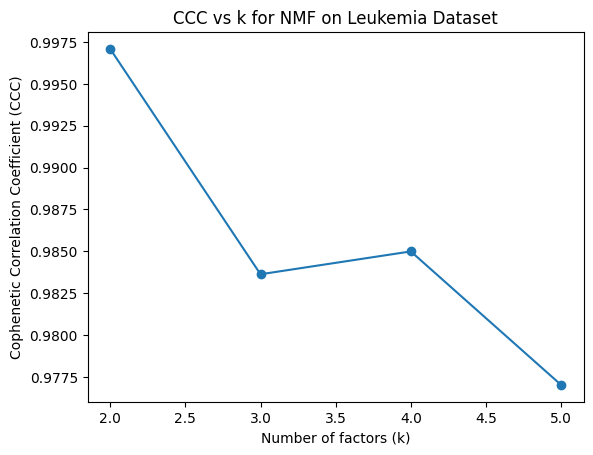

In [ ]:
plt.plot(K_range, ccc_values, marker="o")
plt.xlabel("Number of factors (k)")
plt.ylabel("Cophenetic Correlation Coefficient (CCC)")
plt.title("CCC vs k for NMF on Leukemia Dataset")
plt.show()

In [ ]:
best_k = 5
print(f"Best k based on CCC = {best_k}")

Best k based on CCC = 5


In [ ]:
nmf_final = NMF(n_components=best_k, init="random", max_iter=2000, random_state=42)

from sklearn.preprocessing import StandardScaler

H_final = nmf_final.fit_transform(X_scaled)
H_final = StandardScaler().fit_transform(H_final)

In [ ]:
from sklearn.svm import SVC
clf2 = SVC(kernel="rbf", C=10, gamma="scale")
clf2.fit(H_final, y)
y_pred2 = clf2.predict(H_final)
nmf_acc = accuracy_score(y, y_pred2)
print("Accuracy (SVM on H):", nmf_acc)

Accuracy (SVM on H): 1.0


In [ ]:
print(f"Accuracy using H matrix (NMF, k={best_k}): {nmf_acc:.4f}")
print(f"Baseline vs NMF accuracy: {baseline_acc:.4f} vs {nmf_acc:.4f}")

Accuracy using H matrix (NMF, k=5): 1.0000
Baseline vs NMF accuracy: 1.0000 vs 1.0000
